<a href="https://colab.research.google.com/github/Server-security-visualization/AI/blob/main/KISA/Malware/Training_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setting dataset and github

In [2]:
!mkdir -p ./dataset
!unzip /content/drive/MyDrive/server_security/colab/KISA/Malware/dataset/img256.zip -d ./dataset
!cp /content/drive/MyDrive/server_security/colab/KISA/Malware/dataset/malware1.csv ./dataset
!git clone https://github.com/Server-security-visualization/AI.git

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./dataset/img256/a415947de7c148cbea0ad5ad3d933ffd.png  
  inflating: ./dataset/img256/a417e0673ee60dbd9ceaee8df251e6e2.png  
  inflating: ./dataset/img256/a4185e4d40e16361c5e46fa4fbc2f81c.png  
  inflating: ./dataset/img256/a419fa9ce4da3e5cd2b4d5a8c125d478.png  
  inflating: ./dataset/img256/a420fbe8235b8036ac8346b892253d98.png  
  inflating: ./dataset/img256/a43c7151a929e80993eb507240f24e2a.png  
  inflating: ./dataset/img256/a44005e45af542ef17d5ae66c19f8426.png  
  inflating: ./dataset/img256/a44512dcf380a2d88dc2f09ec4c4b1a3.png  
  inflating: ./dataset/img256/a446da6592f1ca3f0dc9fd62792463e1.png  
  inflating: ./dataset/img256/a450dc9e40d5107bf0cd4093f8ed8b97.png  
  inflating: ./dataset/img256/a4555781575b8a752704238c29f9a86e.png  
  inflating: ./dataset/img256/a455e718b226c610c35670e860309a20.png  
  inflating: ./dataset/img256/a45652571455ce98c5f0b928751f8cbe.png  
  inflating: ./dataset/img256/a461f293322fd236d0010ffd21f0bfda.png 

# import

In [73]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import os
from matplotlib import pyplot as plt
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
%matplotlib inline

# Load && Hyper Parameter

In [74]:
img_path = "./dataset/img256"
image_w = 256
image_h = 256
input_shape = (image_w, image_h, 1)

In [75]:
malware_df =pd.read_csv("./dataset/malware1.csv")
malware_df.head()

,Unnamed: 0,vir,png,len,malware
0,0,0003c3dd20cd99cf4555ab7c9232ec9c.vir,0003c3dd20cd99cf4555ab7c9232ec9c.png,192902,1
1,1,000590557e79980e147c3ff6521ec5cc.vir,000590557e79980e147c3ff6521ec5cc.png,199684,1
2,2,0006c099239df9bcaab4c3cbc85e6ff8.vir,0006c099239df9bcaab4c3cbc85e6ff8.png,42340,0
3,3,000fbf210ae21ff7604c025e1763a149.vir,000fbf210ae21ff7604c025e1763a149.png,440988,1
4,4,00123e9b2a49b6750df39ad0e86508e2.vir,00123e9b2a49b6750df39ad0e86508e2.png,614478,0


# Create Train, Val Dataset

In [76]:
x = []
y = []

for idx, row in tqdm(malware_df.iterrows()):
    path = f"{img_path}/{row['png']}"
    malware_class = row['malware']
    
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = img.reshape(image_w,image_h,1)
    
    x.append(img/255.)
    y.append(malware_class)
    
x = np.array(x)
y = np.array(y)
    
train_img, val_img, train_label, val_label = train_test_split(x, 
                                                  y, 
                                                  stratify=y, 
                                                  test_size=0.1)

15000it [00:09, 1565.54it/s]


In [77]:
train_img.shape, val_img.shape, train_label.shape, val_label.shape

((13500, 256, 256, 1), (1500, 256, 256, 1), (13500,), (1500,))

In [78]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_img, train_label)).shuffle(buffer_size=100000).batch(64)
val_dataset = tf.data.Dataset.from_tensor_slices((val_img, val_label)).batch(64)

# Def Model

In [79]:
def VGG16():
    vgg16 = tf.keras.applications.vgg16.VGG16(include_top=False, weights=None, input_shape=input_shape)
    
    model = tf.keras.models.Sequential([
        vgg16,
        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=['accuracy'])
    return model

In [80]:
def ResNet50():
    resnet50 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights=None, input_shape=input_shape)
    
    model = tf.keras.models.Sequential([
        resnet50,
        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=['accuracy'])
    return model

In [106]:
def ResNet101():
    resnet101 = tf.keras.applications.resnet.ResNet101(include_top=False, weights=None, input_shape=input_shape)
    
    model = tf.keras.models.Sequential([
        resnet101,
        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=['accuracy'])
    return model

In [118]:
def InceptionV3():
    inceptionv3 = tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights=None, input_shape=input_shape)
    
    model = tf.keras.models.Sequential([
        inceptionv3,
        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=['accuracy'])
    return model

# Train

In [116]:
folder_name = "malware_inceptionv3"
if not os.path.exists(f"./model"):
    os.mkdir(f"./model")
    print("./model")
if not os.path.exists(f"./img"):
    os.mkdir(f"./img")
    print("./img")
if not os.path.exists(f"./model/{folder_name}"):
    os.mkdir(f"./model/{folder_name}")
    print(f"create ./model/{folder_name}")
if not os.path.exists(f"./img/{folder_name}"):
    os.mkdir(f"./img/{folder_name}")
    print(f"create ./img/{folder_name}")

create ./model/malware_inceptionv3
create ./img/malware_inceptionv3


In [119]:
model = InceptionV3()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802208  
                                                                 
 dense_12 (Dense)            (None, 6, 6, 512)         1049088   
                                                                 
 batch_normalization_100 (Ba  (None, 6, 6, 512)        2048      
 tchNormalization)                                               
                                                                 
 global_average_pooling2d_6   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_13 (Dense)            (None, 1)                 513       
                                                                 
Total params: 22,853,857
Trainable params: 22,818,401


In [120]:
save_path = f"./model/{folder_name}/"
checkpoint_path = save_path+"/model_{epoch}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=0)

In [121]:
history = model.fit(train_dataset, 
                    epochs=30, 
                    validation_data=val_dataset, 
                    callbacks=[cp_callback])

Epoch 1/30
211/211 [==============================] - 73s 142ms/step - loss: 0.5458 - accuracy: 0.7371 - val_loss: 0.6393 - val_accuracy: 0.7000
Epoch 2/30
211/211 [==============================] - 23s 110ms/step - loss: 0.4463 - accuracy: 0.7899 - val_loss: 0.7624 - val_accuracy: 0.6813
Epoch 3/30
211/211 [==============================] - 23s 111ms/step - loss: 0.4024 - accuracy: 0.8155 - val_loss: 0.5153 - val_accuracy: 0.7873
Epoch 4/30
211/211 [==============================] - 23s 108ms/step - loss: 0.3718 - accuracy: 0.8328 - val_loss: 1.0566 - val_accuracy: 0.6087
Epoch 5/30
211/211 [==============================] - 23s 108ms/step - loss: 0.3400 - accuracy: 0.8541 - val_loss: 0.6219 - val_accuracy: 0.7867
Epoch 6/30
211/211 [==============================] - 23s 108ms/step - loss: 0.3173 - accuracy: 0.8644 - val_loss: 0.6558 - val_accuracy: 0.7467
Epoch 7/30
211/211 [==============================] - 23s 108ms/step - loss: 0.2909 - accuracy: 0.8780 - val_loss: 0.6702 - val_ac

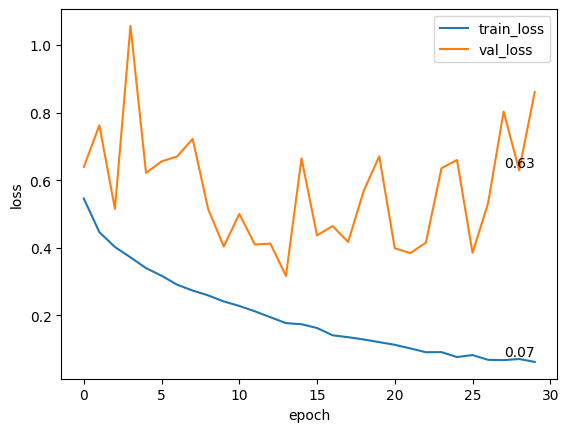

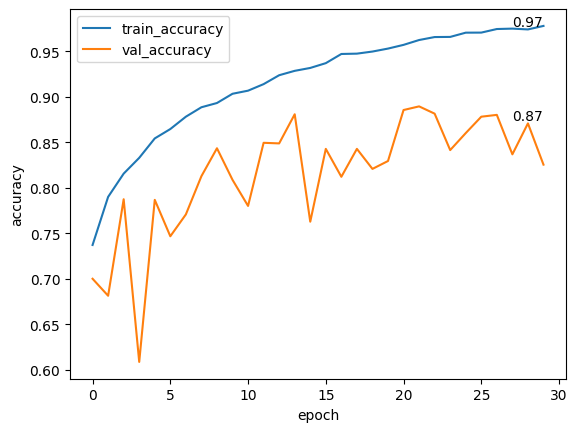

In [122]:
idx = 28
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.text(idx, history.history['loss'][idx], '%.2f' %  history.history['loss'][idx], ha='center', va='bottom', size = 10)
plt.text(idx, history.history['val_loss'][idx], '%.2f' %  history.history['val_loss'][idx], ha='center', va='bottom', size = 10)

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.savefig(f"./img/{folder_name}/loss.png")
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.text(idx, history.history['accuracy'][idx], '%.2f' %  history.history['accuracy'][idx], ha='center', va='bottom', size = 10)
plt.text(idx, history.history['val_accuracy'][idx], '%.2f' %  history.history['val_accuracy'][idx], ha='center', va='bottom', size = 10)

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.savefig(f"./img/{folder_name}/acc.png")
plt.show()

# Save Goole Drive

In [123]:
!zip -r inceptionv3_model.zip ./model/malware_inceptionv3/* 

  adding: model/malware_inceptionv3/checkpoint (deflated 43%)
  adding: model/malware_inceptionv3/model_10.ckpt.data-00000-of-00001 (deflated 8%)
  adding: model/malware_inceptionv3/model_10.ckpt.index (deflated 79%)
  adding: model/malware_inceptionv3/model_11.ckpt.data-00000-of-00001 (deflated 8%)
  adding: model/malware_inceptionv3/model_11.ckpt.index (deflated 79%)
  adding: model/malware_inceptionv3/model_12.ckpt.data-00000-of-00001 (deflated 8%)
  adding: model/malware_inceptionv3/model_12.ckpt.index (deflated 79%)
  adding: model/malware_inceptionv3/model_13.ckpt.data-00000-of-00001 (deflated 8%)
  adding: model/malware_inceptionv3/model_13.ckpt.index (deflated 79%)
  adding: model/malware_inceptionv3/model_14.ckpt.data-00000-of-00001 (deflated 8%)
  adding: model/malware_inceptionv3/model_14.ckpt.index (deflated 79%)
  adding: model/malware_inceptionv3/model_15.ckpt.data-00000-of-00001 (deflated 8%)
  adding: model/malware_inceptionv3/model_15.ckpt.index (deflated 79%)
  adding

In [124]:
!mkdir /content/drive/MyDrive/server_security/colab/KISA/Malware/img/inceptionv3
!mv ./inceptionv3_model.zip /content/drive/MyDrive/server_security/colab/KISA/Malware/model
!mv ./img/malware_inceptionv3/* /content/drive/MyDrive/server_security/colab/KISA/Malware/img/inceptionv3